# Purpose: 
Generate a fire perimeter in GeoJSON based on the input pre and post flight images

In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/uavsar-main/python").resolve()
sys.path.append(str(utils_path))

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show
# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from process_utils import (preprocess_data, 
                           superpixel_segmentation,
                           get_superpixel_model_labels,
                           convert_labels_to_gdf,
                           filter_by_area,
                           merge_geojson,
                           tv_denoise,)
from nd_utils import (get_superpixel_means_as_features,
                      get_superpixel_stds_as_features,get_superpixel_medians_as_features,
                      get_array_from_features)
# # from process_utils import (preprocess_data, 
#                            get_model_labels)
from rio_utils import (reproject_arr_to_match_profile)
from shapely.geometry import Polygon
from shapely.geometry import Point

In [2]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the preprocessed images
- `superpixel_labels_list` (list): a list containing the paths to the superpixel labels

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
        transform = ds.transform
    return band, profile, transform

In [4]:
# Path to the folder with the preprocessed images
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km")

tifs = sorted(list(data_dir.glob('./*rectangle_preprocessed*.tif')))
tifs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km/hv_0_45km_40km_rectangle_preprocessed_interpolated.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km/hv_1_45km_40km_rectangle_preprocessed_interpolated.tif')]

---
Open the preprocessed images and load the superpixel segmentation corresponded to the pre- and post- fire.

- Let `hv_0` correspond to the pre-fire image and `hv_1` correspond to the post-fire image. 
- Let `profile` and `transform` correspond to the pre-fire image.
- Let `superpixel_labels` be the output of the segmentation

In [5]:
# open the tifs
bands_tv, profiles, transforms = zip(*map(open_one, tifs))
hv_0 = bands_tv[0]
hv_1 = bands_tv[1]
profile = profiles[0]
transform = transforms[0]

In [6]:
hv_0 = denoise(hv_0,5)
hv_1 = denoise(hv_1,5)

---
This is the preprocessed raster image we will work with to extract the fire perimeter

In [7]:
# compute log ratio and filter out the vegetation gain by setting to no change.
log_ratio = 10*np.log10(hv_0/hv_1)

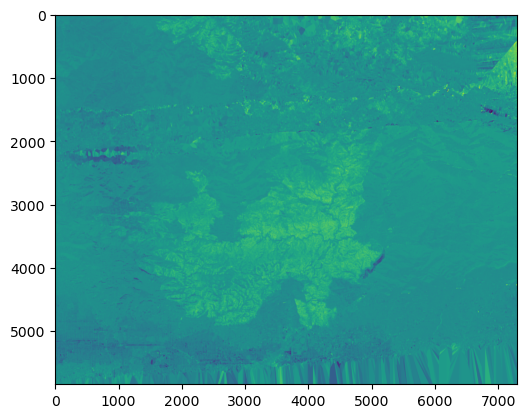

In [8]:
plt.imshow(log_ratio)

In [9]:
# Load if we have performed segmentation previously

superpixel_labels = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km/superpixel_labels_230727_231017_min1000.npy")

In [10]:
# # Load if we have performed segmentation previously

# superpixel_labels = np.load("/shared/Wildfire/Jeremiah_Workspace/data/superpixel_labels_230727_231017_min1000.npy")

In [11]:
# # Run this if we do not have the saved np array

# superpixel_labels = superpixel_segmentation(hv_0, hv_1, min_size=100)

# # save this np array to save run time for future runs
# superpixel_out_path = "latuna_bilinear_inc.npy"
# np.save(superpixel_out_path, superpixel_labels)

In [12]:
print("superpizel_labels: ")
print(superpixel_labels)

superpizel_labels: 
[[   0    0    0 ...  119  119  119]
 [   0    0    0 ...  119  119  119]
 [   0    0    0 ...  119  119  119]
 ...
 [8786 8786 8786 ... 8322 8322 8322]
 [8786 8786 8786 ... 8322 8322 8322]
 [8786 8786 8786 ... 8322 8322 8322]]


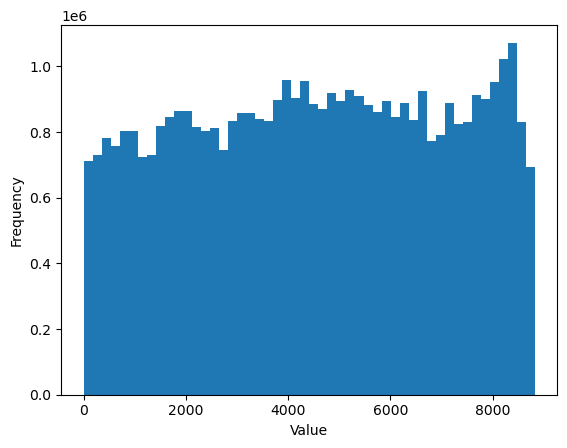

In [13]:
import matplotlib.pyplot as plt

# Check the distribution of the data
plt.hist(superpixel_labels.flatten(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Classification

In [14]:
# np.seterr(divide='ignore', invalid='ignore')##
# # Extracting features from the segmentation
# mean_features = get_superpixel_means_as_features(superpixel_labels, log_ratio)
# std_features = get_superpixel_stds_as_features(superpixel_labels, log_ratio)
# print("mean_features", mean_features)
# print("std_features", std_features)

In [15]:
pre_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/rectangle_45km_40km/pre_merged_alpha1_image_rectangle.npy")
post_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/post_merged_alpha_image_test_aligned_rectangle.npy")
slope = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Slope/slope_without_crop.npy")

In [16]:
# Get common minimum shape across all relevant inputs
min_rows = min(superpixel_labels.shape[0], log_ratio.shape[0], pre_alpha1.shape[0], post_alpha1.shape[0], slope.shape[0])
min_cols = min(superpixel_labels.shape[1], log_ratio.shape[1], pre_alpha1.shape[1], post_alpha1.shape[1], slope.shape[1])
print("min_rows", min_rows)
# Crop all arrays to the same shape
superpixel_labels_cropped = superpixel_labels[:min_rows, :min_cols]
log_ratio_cropped = log_ratio[:min_rows, :min_cols]
pre_alpha1_cropped = pre_alpha1[:min_rows, :min_cols]
post_alpha1_cropped = post_alpha1[:min_rows, :min_cols]
slope_cropped = slope[:min_rows, :min_cols]
print(superpixel_labels_cropped.shape)

# Feature extraction
np.seterr(divide='ignore', invalid='ignore')
mean_log_ratio = get_superpixel_means_as_features(superpixel_labels_cropped, log_ratio_cropped)
median_pre_alpha1 = get_superpixel_medians_as_features(superpixel_labels_cropped, pre_alpha1_cropped)
median_post_alpha1 = get_superpixel_medians_as_features(superpixel_labels_cropped, post_alpha1_cropped)
diff_alpha1 = median_pre_alpha1 - median_post_alpha1
median_slope = get_superpixel_medians_as_features(superpixel_labels_cropped, slope_cropped)


min_rows 5839
(5839, 7290)


In [17]:
print("pre_alpha1", pre_alpha1.shape)

pre_alpha1 (5839, 7290)


In [18]:
print("post_alpha1", post_alpha1.shape)

post_alpha1 (5839, 7290)


In [19]:
print("slope", slope.shape)

slope (5839, 7290)


In [20]:
# np.seterr(divide='ignore', invalid='ignore')
# #Extracting features
# mean_log_ratio = get_superpixel_means_as_features(superpixel_labels, log_ratio)
# median_pre_alpha1 = get_superpixel_medians_as_features(superpixel_labels, pre_alpha1)
# median_post_alpha1 = get_superpixel_medians_as_features(superpixel_labels, post_alpha1)
# diff_alpha1 = median_pre_alpha1 - median_post_alpha1
# median_slope = get_superpixel_medians_as_features(superpixel_labels, slope)




In [21]:
unique_superpixel_labels = np.unique(superpixel_labels)
unique_superpixel_labels_reshape = unique_superpixel_labels.reshape(-1,1)

In [22]:
print(unique_superpixel_labels_reshape.shape)

(8828, 1)


In [23]:
print(mean_log_ratio.shape)

(8828, 1)


In [24]:
print(diff_alpha1.shape)

(8828, 1)


In [25]:
print(median_slope.shape)

(8828, 1)


In [26]:
# I need to check how to make a dataframe using these columns
fire_data = np.hstack([unique_superpixel_labels_reshape,mean_log_ratio, diff_alpha1, median_slope])

In [27]:
# unique_vals = np.unique(superpixel_labels)
# print("Unique values in superpixel_labels:", unique_vals)


In [28]:
index = 4
print(f"median_pre_alpha1[{index}] = {median_pre_alpha1[index]}")
print(f"median_post_alpha1[{index}] = {median_post_alpha1[index]}")
print(f"diff_alpha1[{index}] = {diff_alpha1[index]}")
print(f"Manual check: {median_pre_alpha1[index]} - {median_post_alpha1[index]} = {median_pre_alpha1[index] - median_post_alpha1[index]}")


median_pre_alpha1[4] = [27.24485297]
median_post_alpha1[4] = [28.56198788]
diff_alpha1[4] = [-1.3171349]
Manual check: [27.24485297] - [28.56198788] = [-1.3171349]


In [29]:
unique_vals = np.unique(diff_alpha1)
print("Unique values in diff_alpha1:", unique_vals)

Unique values in diff_alpha1: [-35.68423906 -32.23500403 -30.47456773 ...  47.3994262   47.71403374
          nan]


In [30]:
import pandas as pd
# Create pandas dataframe with column names
df = pd.DataFrame(fire_data, columns=['superpixel_label','mean_log_ratio', 'diff_alpha1', 'median_slope'])
print(df)

      superpixel_label  mean_log_ratio  diff_alpha1  median_slope
0                  0.0       -1.473122    -0.530336        1024.0
1                  1.0       -1.657665    -2.113297        1026.0
2                  2.0       -1.810292    -3.392884        1051.0
3                  3.0       -1.962264    -4.927335        1059.0
4                  4.0       -2.193945    -1.317135        1089.0
...                ...             ...          ...           ...
8823            8823.0       -4.468092          NaN         162.0
8824            8824.0       -0.920794          NaN         162.0
8825            8825.0       -2.064869          NaN         169.0
8826            8826.0        0.716452          NaN         172.0
8827            8827.0        0.269859          NaN         172.0

[8828 rows x 4 columns]


In [31]:
# Calculate the number of non-null values in each row
non_null_counts = df.count(axis=1)

# Get the total number of columns
num_columns = df.shape[1]

# Determine complete rows
complete_rows = df[non_null_counts == num_columns]

# Count the number of complete rows
num_complete_rows = len(complete_rows)
print(num_complete_rows)

6185


In [32]:
# retain only complete rows
df_cleaned = df.dropna()
print(len(df_cleaned))
# pd.set_option('display.max_rows',None)
print(df_cleaned)

6185
      superpixel_label  mean_log_ratio  diff_alpha1  median_slope
0                  0.0       -1.473122    -0.530336        1024.0
1                  1.0       -1.657665    -2.113297        1026.0
2                  2.0       -1.810292    -3.392884        1051.0
3                  3.0       -1.962264    -4.927335        1059.0
4                  4.0       -2.193945    -1.317135        1089.0
...                ...             ...          ...           ...
8474            8474.0       -1.094045    -9.833585         210.0
8502            8502.0       -2.843617   -19.515145         155.0
8553            8553.0       -1.173788     2.152407         222.0
8554            8554.0       -0.413614    -9.099993         218.0
8559            8559.0       -0.951501     2.450465         223.0

[6185 rows x 4 columns]


In [33]:
df_cleaned_for_model = df_cleaned.drop('superpixel_label', axis=1) # we don't want to use the superpixel label as a feature
print(df_cleaned_for_model)

      mean_log_ratio  diff_alpha1  median_slope
0          -1.473122    -0.530336        1024.0
1          -1.657665    -2.113297        1026.0
2          -1.810292    -3.392884        1051.0
3          -1.962264    -4.927335        1059.0
4          -2.193945    -1.317135        1089.0
...              ...          ...           ...
8474       -1.094045    -9.833585         210.0
8502       -2.843617   -19.515145         155.0
8553       -1.173788     2.152407         222.0
8554       -0.413614    -9.099993         218.0
8559       -0.951501     2.450465         223.0

[6185 rows x 3 columns]


In [34]:
from sklearn.cluster import KMeans
# model = KMeans(n_clusters=4, ##3
#               n_init=4,
#               random_state=1)
# classes = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = classes + 1
# classes
# Selecting the K-Means model with n_clusters=2
model = KMeans(n_clusters=2, n_init=10,random_state=1)

In [35]:
# labeled_data = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = get_array_from_features(superpixel_labels, labeled_data)
# gdf = convert_labels_to_gdf(classes, profile)


In [36]:
classes = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = get_array_from_features(superpixel_labels, labeled_data)
# # gdf = convert_labels_to_gdf(classes, profile)

In [37]:
classes

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [38]:
# Start with all background as 0
model_output = np.zeros_like(superpixel_labels)

# Replace superpixel IDs with cluster class (0 or 1)
for i in range(len(classes)):
    label_id = int(df_cleaned.iat[i, 0])
    cluster_class = classes[i]
    model_output[superpixel_labels == label_id] = cluster_class + 1  # Optional: +1 to match Burned=1, Unburned=2

In [39]:
# print(len(classes))

print(df_cleaned.shape)

(6185, 4)


In [40]:
# model_output = np.zeros_like(superpixel_labels)

# # Replace superpixel labels with cluster class (0 or 1)
# # Then +1 to shift classes to 1 and 2 (for visualization)
# for i in range(len(classes)):
#     label = int(df_cleaned.iat[i, 0])    # superpixel ID
#     cls = int(classes[i]) + 1            # 1 or 2
#     model_output[superpixel_labels == label] = cls

In [41]:
# # Dr.Uma Code
# model_output = superpixel_labels
# # model_output = np.empty_like(superpixel_labels)
# # model_output[:] = 0 # 0 indicates missing values since classes are numbered 1, 2, ...

# for i in range(len(classes)):
#     # print(i)
#     # print(df_cleaned.iat[i,0])
#     # print(classes[i])
#     model_output[model_output==int(df_cleaned.iat[i,0])] = classes[i]
#     # model_output = np.where(model_output == int(df_cleaned.iat[i,0]),classes[i],0) # logically this is correct
#     # np.put(model_output,np.where(model_output==int(df_cleaned.iat[i,0])),classes[i])
#     # model_output.replace(df_cleaned.iat[i,0],classes[i])
# # print(superpixel_labels)
# # print(model_output)

In [42]:
print(model_output)

[[2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [43]:
print(np.unique(model_output))

[0 1 2]


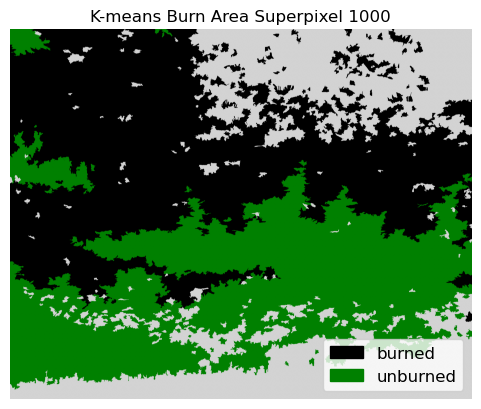

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Define color map
colors = ['lightgray', 'black', 'green']  # 0 = background, 1 = burned, 2 = unburned
cmap = mcolors.ListedColormap(colors)
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Legend
legend_patches = [
    mpatches.Patch(color='black', label='burned'),
    mpatches.Patch(color='green', label='unburned')
]

# Plot
plt.imshow(model_output, cmap=cmap, norm=norm)
plt.title('K-means Burn Area Superpixel 1000')
plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.axis('off')
plt.show()

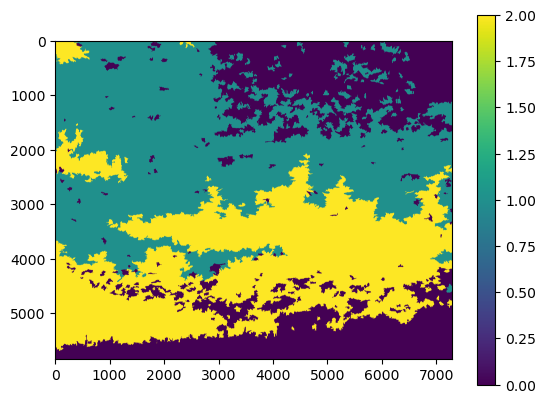

In [59]:
plt.imshow(model_output)
plt.colorbar()